In [1]:
import numpy as np
import itertools
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, AncillaRegister, transpile
from qiskit_aer import Aer




In [2]:
simulator = Aer.get_backend('aer_simulator_statevector')

In [3]:
n=5
Bfunc=[[1, -4], [-2, 5], [-1, 2, 3], [-1, -2, -4],[-3, 4, -5],[3, 4]]
# Bfunc=[[1, -4], [-2, 5], [-1, 2, 3], [-1, -2, -4],[3, 4],[-3, 4, -5]]
# Bfunc=[[3, 4], [1,-4], [-1, -2, -4], [-1, 2, 3], [-2, 5], [-3,-5], [-1,-3]]


In [4]:
def clause_circ(clause,ar,qc):
    qc.reset(ar[0])
        
    for l in clause:
        if l>0:
            qc.x(l-1)

    qc.mcx(list(np.abs(clause)-[1]), ar[0])
    
    for l in clause:
        if l>0:
            qc.x(l-1)

In [5]:

def Sat_solver(Bf,n):
    qr=QuantumRegister(n, 'q')
    cr=ClassicalRegister(n, 'c')
    ar=AncillaRegister(1, 'a')
    qc=QuantumCircuit(qr, cr, ar)
    
    qc.h(qr)
    
    aq = []
    
    
    for a, C in enumerate(Bf):
        
        clause_circ(C,ar,qc)
        
        Qi=Qi = [[-1-n] for _ in range(n)]
        for l in C:
            count=0
            for i,Ci in enumerate(Bf[:a]):
                for m in Ci:
                    if (abs(m)==abs(l) and m!=l and Ci != C):
                        count+=1
                        Qi[abs(l)-1].append(Ci)  
                        if aq[i][2:] !=[]:  
                            Qi[abs(l)-1]+=aq[i][2:]    
                        break
            
            Qi[abs(l)-1][0]=count   
            if count==0:
                break
        
        min=n
        Min=[]            
        for i in range(len(Qi)):
            if Qi[i][0]>=0 and Qi[i][0]<=min:
                min=Qi[i][0]
                Min=[i]+Qi[i]
                if min==0:
                    break
    
        # print(Min)
        aq.append(Min)
        qc.cx(ar[0], Min[0])
        if Min[1]!=0:
            if Min[1]>1:
                print('More than 1 intersection is not yet fully supported')
            cvci=[]

            for i in C:
                if abs(i) not in np.abs(cvci) and (abs(i)-1!=Min[0]):
                    cvci.append(i) 
            
            for i in Min[2:]:
                cvcj=cvci.copy()
                for j in i:
                    if abs(j) not in np.abs(cvcj) and abs(j)-1!=Min[0]:
                        cvcj.append(j)
                        
                clause_circ(cvcj,ar,qc)
                for j in cvcj:
                    if j not in C:
                        qc.cx(ar[0], abs(j)-1)       
                        break                 
                    # print('cvcj', cvcj)
                
        qc.barrier()
    qc.measure(qr, cr)
    return qc

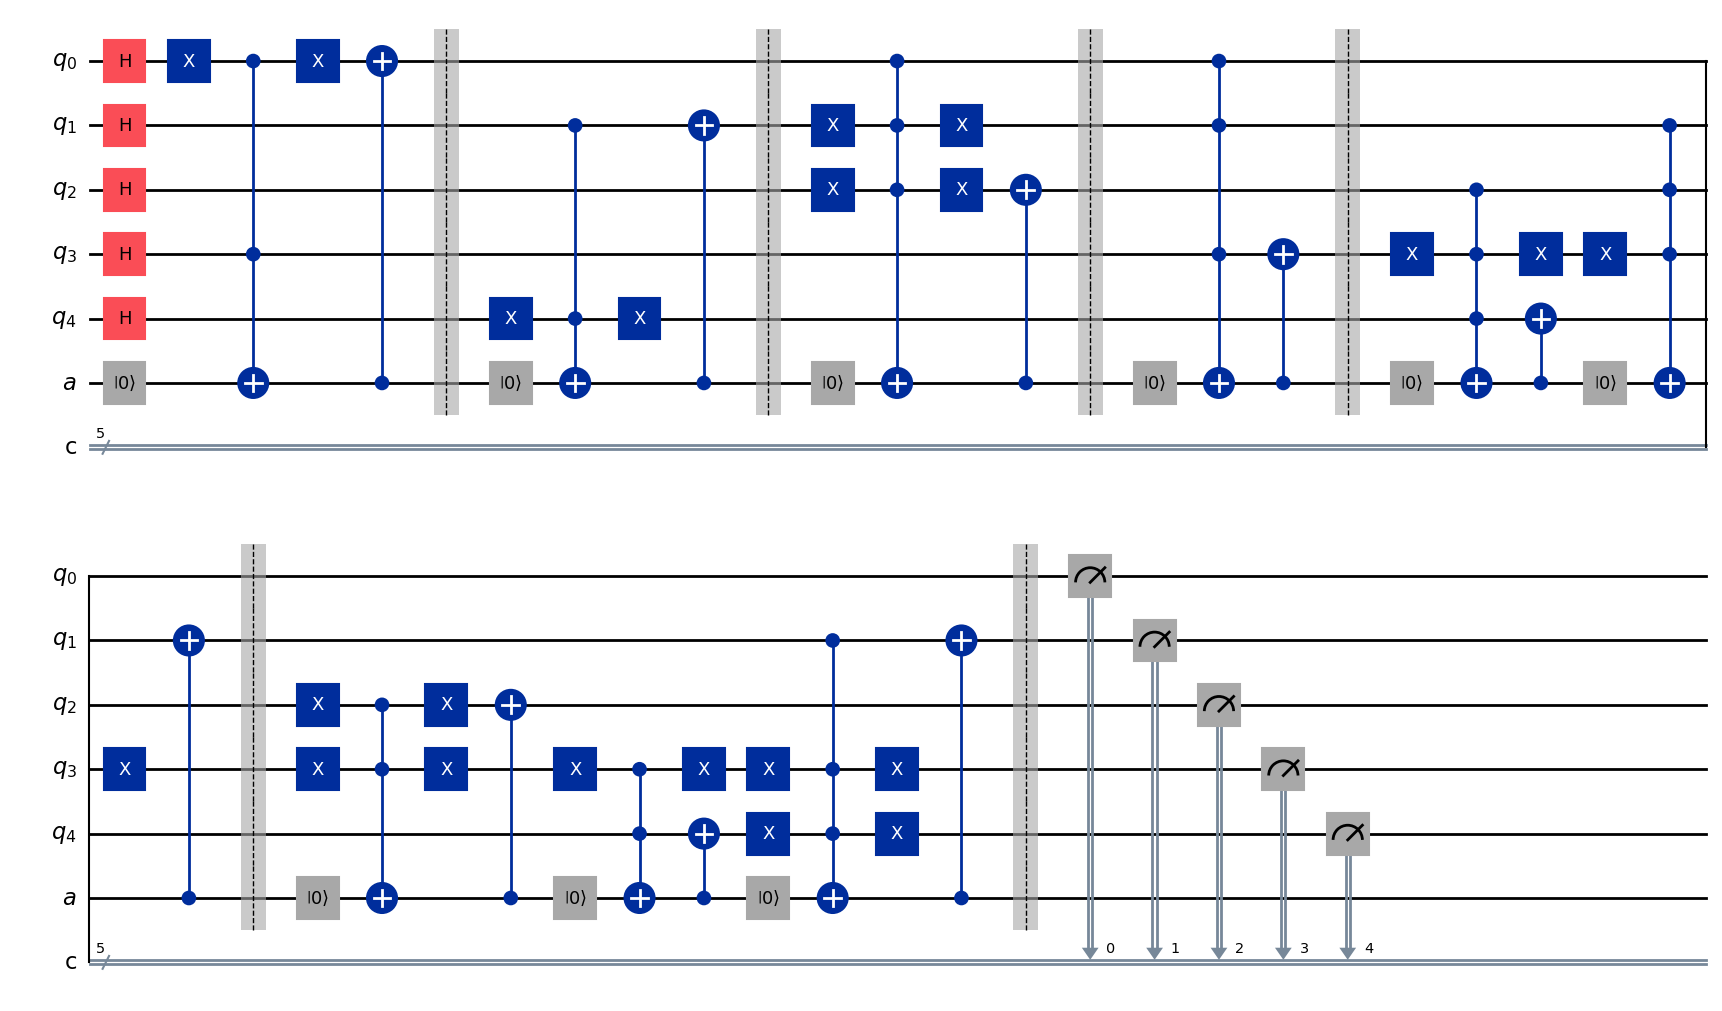

In [6]:
circ=Sat_solver(Bfunc, n)
circ.draw('mpl')

{'00100': 240, '01101': 269, '11101': 120, '00101': 371}
{'00100': 240, '00101': 371, '01101': 269, '11101': 120}
Number of unique outcomes: 4


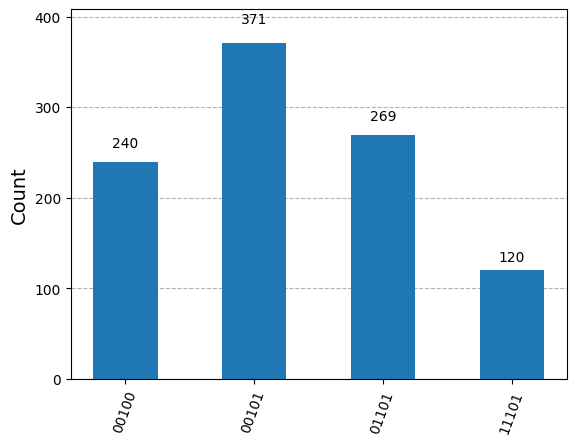

In [7]:
circuit = transpile(circ, simulator)
job = simulator.run(circuit, shots=1000)
result = job.result()

#print(f'backend: {result.backend_name}')
counts = result.get_counts()
print(counts)
sorted_counts = dict(sorted(result.get_counts().items()))
# sorted_counts = dict(sorted(result.get_counts().items(), reverse=True))
print(sorted_counts)
from qiskit.visualization import plot_histogram
print("Number of unique outcomes:", len(counts))

# Plot the histogram of the counts
plot_histogram(counts)
#'0101010111'

In [8]:

def is_satisfiable(clauses, num_vars):
    """
    Find all satisfying assignments for a Boolean SAT problem in CNF.

    Args:
        clauses (list of list of int): Each clause is a list of integers, where
            positive means the variable, negative means its negation.
        num_vars (int): Number of variables.

    Returns:
        list of str: Each string is a satisfying assignment as a bitstring.
    """
    solutions = []
    for assignment in itertools.product([False, True], repeat=num_vars):
        satisfied = True
        for clause in clauses:
            clause_satisfied = False
            for literal in clause:
                var_idx = abs(literal) - 1
                value = assignment[var_idx]
                if (literal > 0 and value) or (literal < 0 and not value):
                    clause_satisfied = True
                    break
            if not clause_satisfied:
                satisfied = False
                break
        if satisfied:
            bitstring = ''.join(str(int(bit)) for bit in assignment)
            solutions.append(bitstring)
    return solutions



In [9]:
s = is_satisfiable(Bfunc, 5)
s, len(s)

(['00100', '10100', '10110', '10111'], 4)

In [10]:
# Convert s (list of solutions) to bitstrings
s_bitstrings = set(bitstring[::-1] for bitstring in s)

# Keys present in counts but not in s
counts_keys = set(counts.keys())
diff_counts_not_in_s = counts_keys - s_bitstrings

# Keys present in s but not in counts
diff_s_not_in_counts = s_bitstrings - counts_keys

print("Keys in counts but not in s:", diff_counts_not_in_s)
print("Keys in s but not in counts:", diff_s_not_in_counts)
print("Counts keys :", sorted(counts_keys))
print("S bitstrings :", sorted(s_bitstrings))
# len(counts_keys), len(s_bitstrings), len(s), len(diff_counts_not_in_s), len(diff_s_not_in_counts)


Keys in counts but not in s: set()
Keys in s but not in counts: set()
Counts keys : ['00100', '00101', '01101', '11101']
S bitstrings : ['00100', '00101', '01101', '11101']
